In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import tf_slim as slim
import functools 

In [2]:
def tensor_size(tensor): 
    from operator import mul 
    return functools.reduce(mul, (d.value for d in tensor.get_shape()), 1)

def next_batch( features, batch_size ): 
    #batch_size = 50

    num_samples = features.shape[0]
    rand_index = np.random.permutation(num_samples)

    cur_index = 0
    
    while True:
        if cur_index + batch_size > num_samples:
            rand_index = np.random.permutation(num_samples)
            cur_index = 0

        cur_index = cur_index + batch_size
        #print(features[ rand_index[cur_index-batch_size:cur_index], : ])
        yield features[ rand_index[cur_index-batch_size:cur_index], : ]
        
        
def runtime_label_ftn( input, p ):

    x = input.copy()
    thres_pos = np.int32 (x.shape[0] * p )
    x = np.sort(x, axis=0)
    thres = x[ thres_pos ]

    x = np.zeros_like(x)
    x[ np.where(input<thres) ] = 1.0
    
    return x

# data load & visualize

In [3]:
features = np.loadtxt("./data/toy_data.npy")
test_vector = np.loadtxt("./data/test_vector.npy")
labels = [-1, 0, 1]

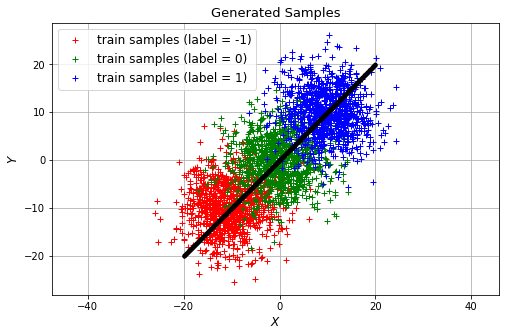

In [4]:
fmts = ["r+", "g+", "b+", "k+", "m+"]
plt.figure(figsize=(8,5))
plt.axis("equal")
for idx in range(len(labels)):
    plt.plot( features[features[:,2] == labels[idx]][:,0], features[features[:,2] == labels[idx]][:,1], fmts[idx], label="train samples (label = {:.0f})".format( labels[idx] ) )

plt.plot(test_vector[:,0], test_vector[:,1], "k.")
plt.xlabel("$X$", fontsize=12)
plt.ylabel("$Y$", fontsize=12)
plt.title("Generated Samples", fontsize=13)
plt.legend(loc="upper left", fontsize=12)
plt.grid()

plt.show()

# model structure

In [5]:
tf.reset_default_graph()

p = 0.8
lamda = 0.1

input = tf.placeholder( tf.float32, [None,2] )
label = tf.placeholder( tf.float32, [None,1] )

with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      weights_initializer=tf.truncated_normal_initializer(stddev=0.01)):

    x = slim.fully_connected(input, 32, scope='fc/fc_1')
    x = slim.fully_connected(x, 128, scope='fc/fc_2')
    x = slim.fully_connected(x, 128, scope='fc/fc_3')
    prediction = slim.fully_connected(x, 1, scope='fc/regression', activation_fn = None )
    confidence = slim.fully_connected(x, 1, scope='fc/confidence', activation_fn = None )
    
confidence = tf.math.sigmoid( confidence ) 

loss_basic = tf.square( label - prediction )

runtime_label = tf.py_func( runtime_label_ftn, [loss_basic, p], [tf.float32] )
loss_basic = tf.reduce_mean( loss_basic )
loss_confidence = loss_basic + lamda* tf.reduce_mean( tf.square(runtime_label-confidence) )

learning_rate = 0.001
global_step = tf.Variable( 0, trainable=False) 
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

update_var_list = tf.get_collection( key = tf.GraphKeys.TRAINABLE_VARIABLES )
#print_var_status( update_var_list )

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_basic_op = optimizer.minimize(loss_basic,global_step=global_step )
    train_op = optimizer.minimize(loss_confidence,global_step=global_step )

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [6]:
total_params = 0 
all_vars = tf.trainable_variables() 
variable_dict = {} 
for var in all_vars: 
    current_tensor_size = tensor_size(var) 
    total_params = total_params + current_tensor_size 
    print("{}, {}, {}".format(var.name, var.get_shape(),current_tensor_size)) 

print( "total parameters =", total_params) 

fc/fc_1/weights:0, (2, 32), 64
fc/fc_1/biases:0, (32,), 32
fc/fc_2/weights:0, (32, 128), 4096
fc/fc_2/biases:0, (128,), 128
fc/fc_3/weights:0, (128, 128), 16384
fc/fc_3/biases:0, (128,), 128
fc/regression/weights:0, (128, 1), 128
fc/regression/biases:0, (1,), 1
fc/confidence/weights:0, (128, 1), 128
fc/confidence/biases:0, (1,), 1
total parameters = 21090


# model training

In [7]:
batch_size = 80

regression_epochs = 4000
confidence_epochs = 4000

with tf.Session() as sess:
    sess.run( tf.global_variables_initializer() )
    
    for idx, x in enumerate( next_batch( features, batch_size) ):
        _loss, _ = sess.run( [loss_basic, train_basic_op], feed_dict={input:x[:,:2],label:x[:,2:3]})
        
        if idx % 1000 == 0:
            print('regression iter :', idx)
            print('regression loss :',_loss)
            
        if idx > regression_epochs:
            break
            
    print()
    
    for idx, x in enumerate( next_batch( features, batch_size) ):
        _loss_confidence, _ = sess.run( [loss_confidence, train_op], feed_dict={input:x[:,:2],label:x[:,2:3]})
        
        if idx % 1000 == 0:
            print('confidence iter :', idx)
            print('confidence loss :', _loss_confidence)
            
        if idx > confidence_epochs:
            break

    _output = sess.run( prediction, feed_dict={input:test_vector})
    _confidence = sess.run( confidence, feed_dict={input:test_vector})

regression iter : 0
regression loss : 0.58751965
regression iter : 1000
regression loss : 0.0880422
regression iter : 2000
regression loss : 0.062421095
regression iter : 3000
regression loss : 0.060785104
regression iter : 4000
regression loss : 0.104907945

confidence iter : 0
confidence loss : 0.12167094
confidence iter : 1000
confidence loss : 0.064694434
confidence iter : 2000
confidence loss : 0.096304595
confidence iter : 3000
confidence loss : 0.13123623
confidence iter : 4000
confidence loss : 0.068907745


# visualize

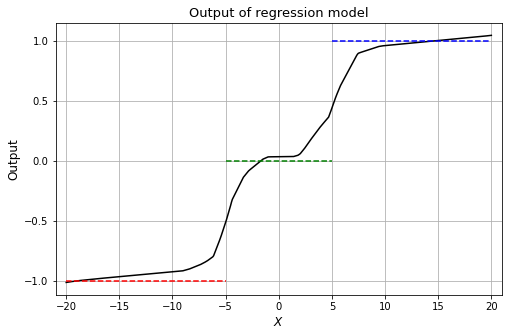

In [8]:
plt.figure(figsize=(8,5))

plt.plot( test_vector[:,0], _output[:,0], "k-" )

plt.plot( [-20,-5], [ labels[0], labels[0] ], "r--")
plt.plot( [-5,5], [ labels[1], labels[1] ], "g--")
plt.plot( [5,20], [ labels[2], labels[2] ], "b--")
plt.title("Output of regression model", fontsize=13)
plt.xlabel("$X$", fontsize=12)
plt.ylabel("Output", fontsize=12)

plt.xlim(-21, 21)

plt.grid()

plt.show()

In [9]:
### For plotting histogram, training samples (x_i, y_i) project on y = x line. ###
sample = np.zeros((3000,3))

idx = 0
u = np.array([1, 1])
for x2, y2, label in features:
    v = np.array([x2, y2])
    proj_u_on_v = (np.dot(u, v)/np.dot(u,u))*u
    sample[idx,:2] += proj_u_on_v
    sample[idx,-1] += label
    idx += 1

data1 = sample[sample[:,-1]==-1]
data2 = sample[sample[:,-1]==0]
data3 = sample[sample[:,-1]==1]

hist1 = np.histogram(data1[:,0], bins=20)
hist2 = np.histogram(data2[:,0], bins=20)
hist3 = np.histogram(data3[:,0], bins=20)

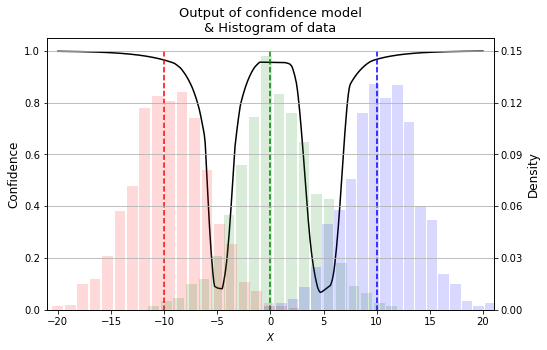

In [10]:
fig = plt.figure(figsize=(8,5))

ax1 = fig.add_subplot(1,1,1)
ax1.set_title("Output of confidence model\n& Histogram of data", fontsize=13)
ax1.set_xlabel("$X$")
ax1.set_ylabel("Confidence", fontsize=12)

ax1.plot( test_vector[:,0], _confidence[:,0], color="k" )
ax1.plot( [-10,-10], [1,0], 'r--' )
ax1.plot( [0,0], [1,0], 'g--' )
ax1.plot( [10,10], [1,0], 'b--' )
ax1.set_xlim(-21, 21)
ax1.set_yticks(np.arange(0,1.01,0.2))
ax1.set_ylim(0,1.05)

ax2 = ax1.twinx()
ax2.bar(hist1[1][1:], hist1[0]/len(data1), width=1, alpha=0.15, color="red")
ax2.bar(hist2[1][1:], hist2[0]/len(data2), width=1, alpha=0.15, color="green")
ax2.bar(hist3[1][1:], hist3[0]/len(data3), width=1, alpha=0.15, color="blue")
ax2.set_ylabel("Density", fontsize=12)
ax2.set_yticks(np.arange(0,0.16,0.03))
ax2.set_ylim(0, 0.1575)

plt.grid()

plt.show()

# Back-up (generate sample)

In [ ]:
### generate training samples ###
class_specs = [ [-10, 5, 1000, -1], [0, 5, 1000, 0], [10, 5, 1000, 1] ] # [ mean, std, size, label ]
class_specs = np.array(class_specs, dtype=np.float32)

features = []
labels = []

for idx, class_spec in enumerate(class_specs):
    m = class_spec[0]
    std = class_spec[1]
    size = int(class_spec[2])
    
    x = np.random.normal(loc=m, scale=std, size=(size,1))
    y = np.random.normal(loc=m, scale=std, size=(size,1))
    
    label = np.ones(shape=(size,1)) * class_specs[idx,3]
    labels.append(class_specs[idx,3])
    
    data = np.concatenate((x, y, label), axis=1)

    features.append( data )
    
features = np.concatenate(features, axis=0)

### generate test samples ###
n_len = 500
test_x = np.linspace( -20, 20, n_len ).reshape(-1,1)
test_y = np.linspace( -20, 20, n_len ).reshape(-1,1)
test_vector = np.hstack( (test_x, test_y) )

In [ ]:
np.savetxt("./data/toy_data.npy", features)
np.savetxt("./data/test_vector.npy", test_vector)